# System 2:
### generating byte frequency distributions derived from file first blocks to train and evaluate our models - FFNN, CNN, GRU, LSTM

In [1]:
import os

import numpy as np
import pandas as pd

from toolkit.utils import get_file_types, get_1st_block_bytes, convert_cat2num, byte_frequency_histogram
from toolkit.models import Ffnn, Ffnn2, Cnn, Cnn2, Lstm, Gru
from toolkit.metrics import evaluate_performance, plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Preparation
we follow the same steps in preparing are data. However, we'll be generating byte frequency distributions to use as feature inputs at the models training stage

In [2]:
dir_path = 'govdocs1/'
files_data = get_file_types(dir_path)
df = pd.DataFrame(files_data)

In [3]:
CLASS_NAMES = [
    "doc",
    "pdf",
    "ps",
    "xls",
    "ppt",
    "swf",
    "gif",
    "jpg",
    "png",
    "html",
    "txt",
    "xml"
]

In [4]:
df = df[df['type'].isin(CLASS_NAMES)]

In [5]:
df['size KB'] = df['file'].apply(
    lambda x: float(os.path.getsize(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) / 1024) if os.path.isfile(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) else None
)

print(f"The average file size is: {df['size KB'].mean()}")

The average file size is: 522.8481363551462


In [6]:
df = df.groupby('type').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)

C:\Users\User\AppData\Local\Temp\ipykernel_22152\680528139.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('type').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)


In [7]:
base_dir = os.path.join(os.getcwd(), "govdocs1")
df["1st_block_bytes"] = df["file"].apply(lambda file: get_1st_block_bytes(os.path.join(base_dir, file)))
df["byte_bfh"] = df["1st_block_bytes"].apply(lambda byte_sequences: byte_frequency_histogram(np.array([byte for byte in byte_sequences])))

In [8]:
# checking that our arrays are homogeneous
byte_lengths = df["byte_bfh"].apply(len)
all_same_length = byte_lengths.nunique() == 1

print("byte lengths of each sequence:\n", byte_lengths)
print("all byte sequences of the same length:", all_same_length)

byte lengths of each sequence:
 0        256
1        256
2        256
3        256
4        256
        ... 
23995    256
23996    256
23997    256
23998    256
23999    256
Name: byte_bfh, Length: 24000, dtype: int64
all byte sequences of the same length: True


In [9]:
df["class"] = df["type"].apply(lambda file_type: convert_cat2num(file_type))

In [10]:
df.sample(n=5)

,file,type,size KB,1st_block_bytes,byte_bfh,class
780,501464.doc,doc,129.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"[1772, 9, 6, 3, 4, 0, 16, 21, 2, 4, 0, 0, 2, 6...",1
16100,497142.swf,swf,27.837891,b'FWS\x04Zo\x00\x00x\x00\x05\xfa\x00\x00\x1ex\...,"[302, 81, 54, 31, 62, 39, 61, 29, 32, 44, 25, ...",6
13180,377879.ppt,ppt,47751.000000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"[1995, 270, 13, 5, 5, 8, 7, 5, 10, 9, 20, 6, 6...",5
11924,739517.png,png,62.077148,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[210, 15, 21, 17, 11, 27, 15, 9, 16, 7, 22, 14...",9
7261,039042.jpg,jpg,49.884766,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...,"[382, 71, 24, 30, 30, 21, 22, 21, 17, 14, 11, ...",8


In [11]:
X = np.array([x for x in df["byte_bfh"]])
y = np.array([y for y in df["class"]])

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (24000, 256)
y shape:  (24000,)


In [12]:
# we use the same split ratio 70% training
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
print("X training shape: ", X_train.shape)
print("X validation shape: ", X_val.shape)
print("X testing shape: ", X_test.shape, "\n")
print("y training shape: ", y_train.shape)
print("y validation shape: ", y_val.shape)
print("y testing shape: ", y_test.shape)

X training shape:  (16800, 256)
X validation shape:  (3600, 256)
X testing shape:  (3600, 256) 

y training shape:  (16800,)
y validation shape:  (3600,)
y testing shape:  (3600,)


## 2. Models Training and Evaluation

### Feed Forward Neural Network

#### a. Base FFNN

In [14]:
ffnn = Ffnn(timesteps=256, features=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256, 256)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │       425,997 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,405 (1.75 MB)

 Trainable params: 459,405 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
ffnn_pred = ffnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7596 - loss: 1.2804 - val_accuracy: 0.9014 - val_loss: 0.3624
Epoch 2/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9071 - loss: 0.3075 - val_accuracy: 0.9153 - val_loss: 0.3278
Epoch 3/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9189 - loss: 0.2812 - val_accuracy: 0.9183 - val_loss: 0.3322
Epoch 4/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9329 - loss: 0.2303 - val_accuracy: 0.9239 - val_loss: 0.3215


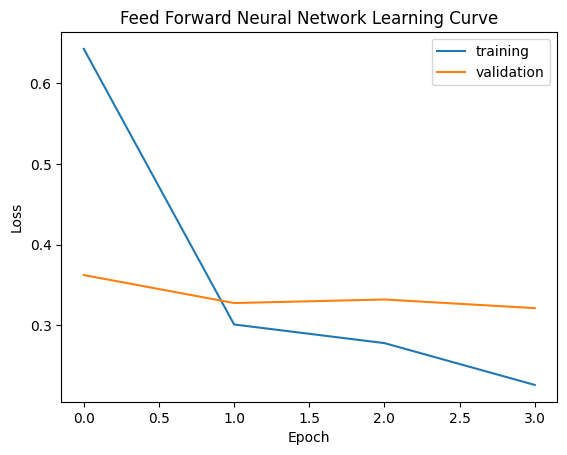

In [16]:
ffnn.plot_learning_curves()

In [17]:
ffnn_pred = ffnn.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [18]:
metrics = evaluate_performance(y_test, ffnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.9147222222222222.
precision	0.9161491319206783.
recall		0.9160609052137275.
f1-score	0.9149543264423364.


In [19]:
ffnn_report = classification_report(y_test, ffnn_pred, target_names=CLASS_NAMES)
print(ffnn_report)

              precision    recall  f1-score   support

         doc       0.97      1.00      0.99       287
         pdf       0.95      0.94      0.94       317
          ps       0.99      0.97      0.98       287
         xls       0.99      0.98      0.99       304
         ppt       0.83      0.93      0.88       307
         swf       0.85      0.71      0.77       307
         gif       0.86      0.96      0.91       308
         jpg       0.89      0.86      0.87       295
         png       0.79      0.75      0.77       311
        html       0.94      0.97      0.95       303
         txt       0.97      0.98      0.97       285
         xml       0.96      0.95      0.96       289

    accuracy                           0.91      3600
   macro avg       0.92      0.92      0.91      3600
weighted avg       0.91      0.91      0.91      3600



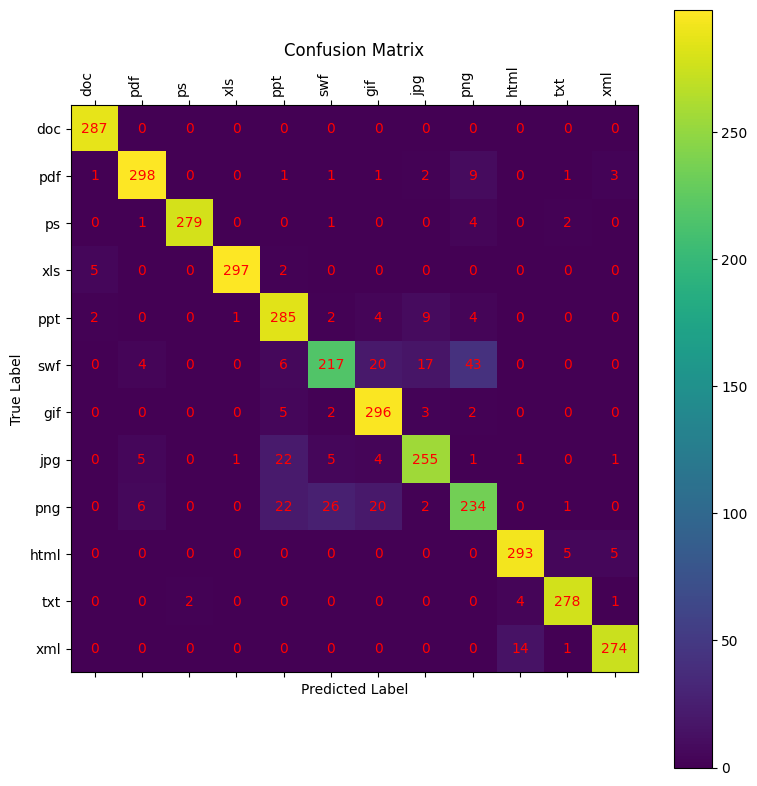

In [20]:
ffnn_cm = confusion_matrix(y_test, ffnn_pred)
plot_confusion_matrix(ffnn_cm, CLASS_NAMES)

#### b. Fine-Tuned FFNN

In [21]:
ffnn2 = Ffnn2(timesteps=256, features=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256, 352)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256, 32)        │        11,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │       106,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,509 (462.93 KB)

 Trainable params: 118,509 (462.93 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
ffnn2_history = ffnn2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7490 - loss: 0.8810 - val_accuracy: 0.8431 - val_loss: 0.4991
Epoch 2/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9087 - loss: 0.3070 - val_accuracy: 0.9200 - val_loss: 0.3042
Epoch 3/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9233 - loss: 0.2619 - val_accuracy: 0.9131 - val_loss: 0.3238
Epoch 4/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9358 - loss: 0.2157 - val_accuracy: 0.9283 - val_loss: 0.2871


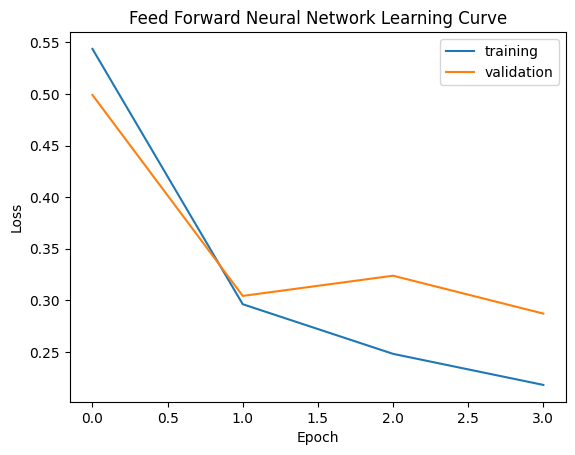

In [23]:
ffnn2.plot_learning_curves()

In [24]:
ffnn2_pred = ffnn2.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [25]:
metrics = evaluate_performance(y_test, ffnn2_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn2.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.9222222222222223.
precision	0.9303855786646386.
recall		0.9237800119739349.
f1-score	0.9241574659680206.


In [26]:
ffnn2_report = classification_report(y_test, ffnn2_pred, target_names=CLASS_NAMES)
print(ffnn2_report)

              precision    recall  f1-score   support

         doc       0.98      1.00      0.99       287
         pdf       1.00      0.92      0.96       317
          ps       1.00      0.98      0.99       287
         xls       0.99      0.99      0.99       304
         ppt       0.93      0.90      0.91       307
         swf       0.67      0.90      0.76       307
         gif       0.94      0.94      0.94       308
         jpg       0.89      0.89      0.89       295
         png       0.90      0.67      0.77       311
        html       0.96      0.95      0.96       303
         txt       0.98      0.99      0.98       285
         xml       0.95      0.97      0.96       289

    accuracy                           0.92      3600
   macro avg       0.93      0.92      0.92      3600
weighted avg       0.93      0.92      0.92      3600



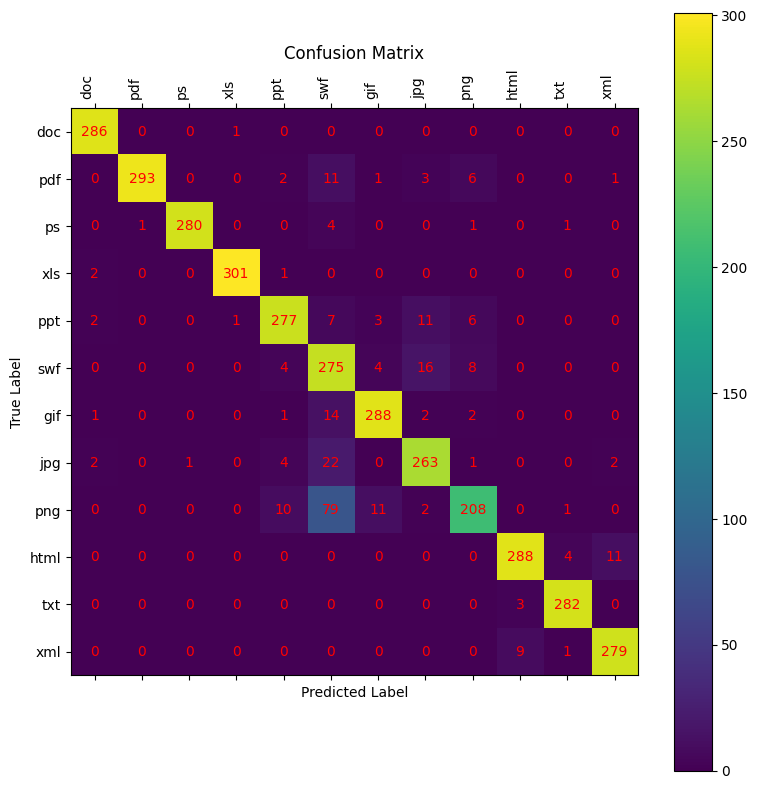

In [27]:
ffnn2_cm = confusion_matrix(y_test, ffnn2_pred)
plot_confusion_matrix(ffnn2_cm, CLASS_NAMES)

### Convolutional Neural Network

#### a. Base CNN

In [28]:
cnn = Cnn(timesteps=256, features=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 254, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 125, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13)             │       103,181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,141 (500.55 KB)

 Trainable params: 128,141 (500.55 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
cnn_history = cnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6853 - loss: 1.8907 - val_accuracy: 0.8583 - val_loss: 0.4889
Epoch 2/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8707 - loss: 0.4007 - val_accuracy: 0.8647 - val_loss: 0.4249
Epoch 3/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8970 - loss: 0.3121 - val_accuracy: 0.8994 - val_loss: 0.3646
Epoch 4/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9172 - loss: 0.2533 - val_accuracy: 0.8836 - val_loss: 0.3735


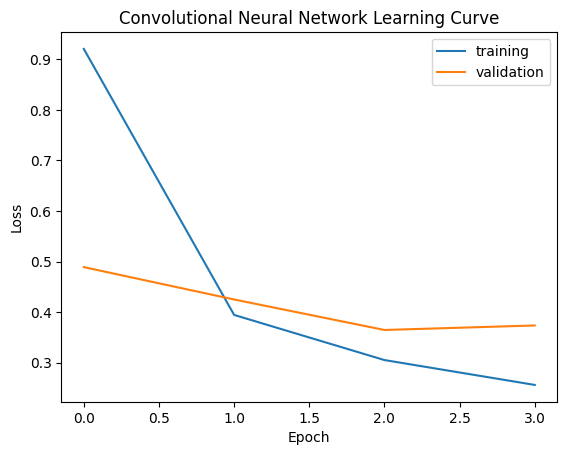

In [30]:
cnn.plot_learning_curves()

In [31]:
cnn_pred = cnn.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [32]:
metrics = evaluate_performance(y_test, cnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.89.
precision	0.9021026936858277.
recall		0.8917994201551163.
f1-score	0.8919011803993846.


In [33]:
cnn_report = classification_report(y_test, cnn_pred, target_names=CLASS_NAMES)
print(cnn_report)

              precision    recall  f1-score   support

         doc       0.98      0.99      0.99       287
         pdf       0.98      0.94      0.96       317
          ps       1.00      0.97      0.98       287
         xls       1.00      0.98      0.99       304
         ppt       0.81      0.60      0.69       307
         swf       0.62      0.92      0.74       307
         gif       0.96      0.91      0.94       308
         jpg       0.79      0.88      0.83       295
         png       0.87      0.69      0.77       311
        html       0.93      0.93      0.93       303
         txt       0.94      0.98      0.96       285
         xml       0.95      0.92      0.93       289

    accuracy                           0.89      3600
   macro avg       0.90      0.89      0.89      3600
weighted avg       0.90      0.89      0.89      3600



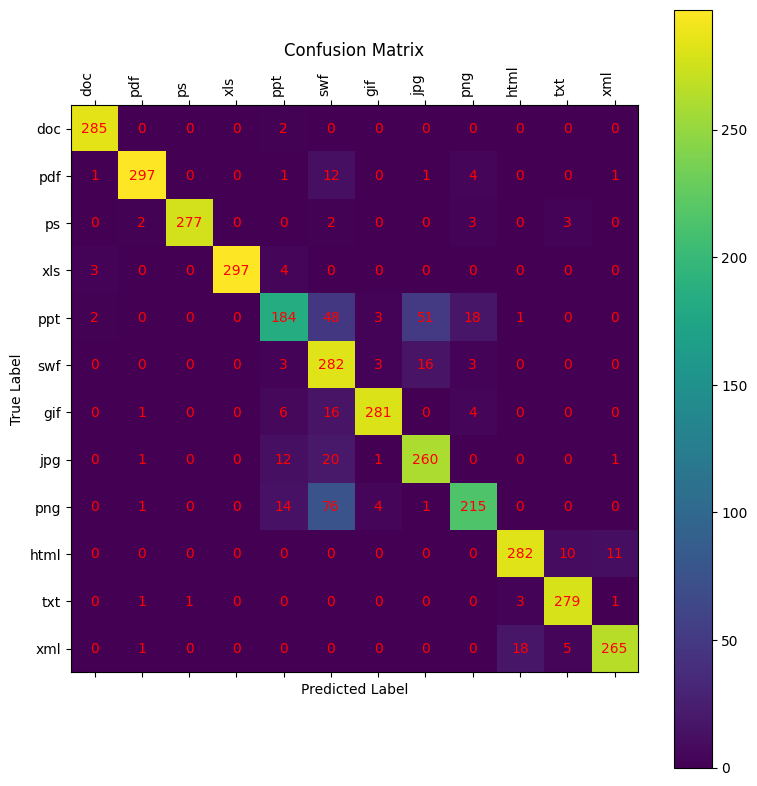

In [34]:
cnn_cm = confusion_matrix(y_test, cnn_pred)
plot_confusion_matrix(cnn_cm, CLASS_NAMES)

#### b. Fine-Tuned CNN

In [35]:
cnn2 = Cnn2(timesteps=256, features=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 254, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 125, 192)       │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 62, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     3,047,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,088,333 (11.78 MB)

 Trainable params: 3,088,333 (11.78 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
cnn2_history = cnn2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.6680 - loss: 1.9925 - val_accuracy: 0.8553 - val_loss: 0.4280
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8675 - loss: 0.4108 - val_accuracy: 0.8967 - val_loss: 0.3248
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8978 - loss: 0.3167 - val_accuracy: 0.9014 - val_loss: 0.2997
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9163 - loss: 0.2510 - val_accuracy: 0.9175 - val_loss: 0.2809
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9294 - loss: 0.2223 - val_accuracy: 0.9228 - val_loss: 0.2539
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9434 - loss: 0.1728 - val_accuracy: 0.9186 - val_loss: 0.2499
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9453 - loss: 0.1567 - val_accuracy: 0.9208 - val_loss: 0.2588
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9530 - loss: 0.1424 - 

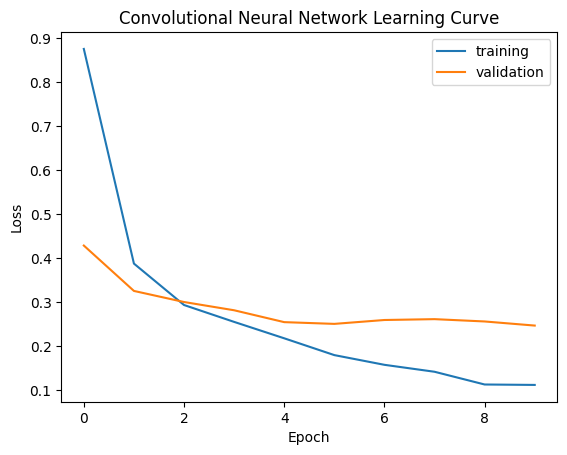

In [37]:
cnn2.plot_learning_curves()

In [38]:
cnn2_pred = cnn2.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [39]:
metrics = evaluate_performance(y_test, cnn2_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn2.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.9313888888888889.
precision	0.9332538798288691.
recall		0.9322479980273095.
f1-score	0.9322164396866834.


In [40]:
cnn2_report = classification_report(y_test, cnn2_pred, target_names=CLASS_NAMES)
print(cnn2_report)

              precision    recall  f1-score   support

         doc       0.99      0.99      0.99       287
         pdf       0.98      0.94      0.96       317
          ps       0.96      0.98      0.97       287
         xls       0.99      0.97      0.98       304
         ppt       0.83      0.84      0.84       307
         swf       0.90      0.90      0.90       307
         gif       0.97      0.96      0.97       308
         jpg       0.83      0.96      0.89       295
         png       0.88      0.83      0.86       311
        html       0.96      0.93      0.95       303
         txt       0.93      0.95      0.94       285
         xml       0.97      0.94      0.95       289

    accuracy                           0.93      3600
   macro avg       0.93      0.93      0.93      3600
weighted avg       0.93      0.93      0.93      3600



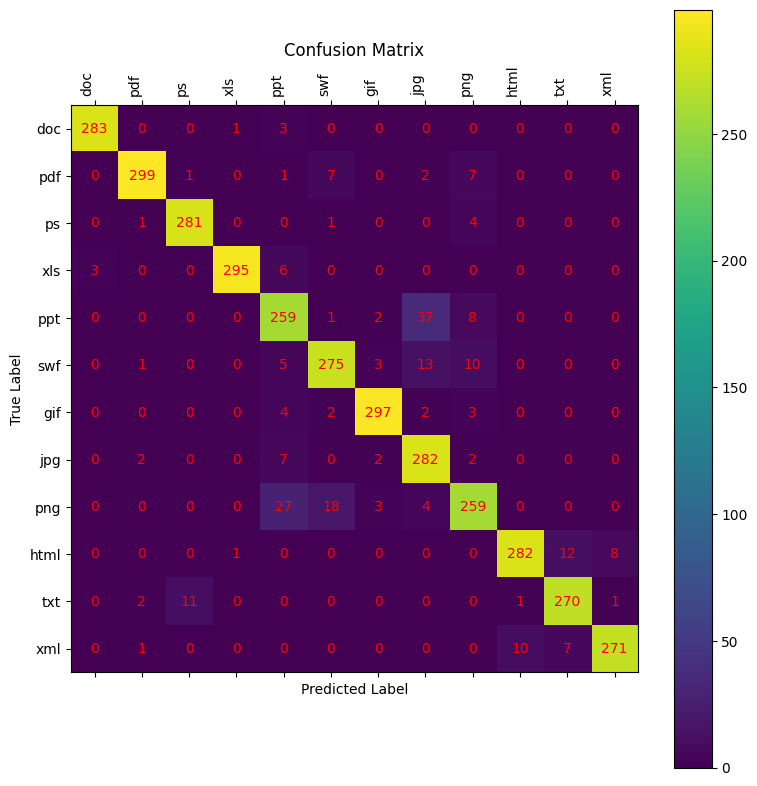

In [41]:
cnn2_cm = confusion_matrix(y_test, cnn2_pred)
plot_confusion_matrix(cnn2_cm, CLASS_NAMES)

### Gated Reccurent Unit

In [42]:
gru = Gru(timesteps=256, features=1)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 136)            │        28,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,749 (120.11 KB)

 Trainable params: 30,749 (120.11 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 63s 115ms/step - accuracy: 0.4740 - loss: 1.4693 - val_accuracy: 0.6531 - val_loss: 0.8537
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 60s 114ms/step - accuracy: 0.7347 - loss: 0.7362 - val_accuracy: 0.8217 - val_loss: 0.5531
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step - accuracy: 0.8372 - loss: 0.4940 - val_accuracy: 0.8603 - val_loss: 0.4340
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 59s 112ms/step - accuracy: 0.8701 - loss: 0.4210 - val_accuracy: 0.8072 - val_loss: 0.5982
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 61s 116ms/step - accuracy: 0.8482 - loss: 0.4668 - val_accuracy: 0.8281 - val_loss: 0.5181
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 60s 115ms/step - accuracy: 0.8428 - loss: 0.4771 - val_accuracy: 0.8569 - val_loss: 0.4357
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 61s 116ms/step - accuracy: 0.8616 - loss: 0.4226 - val_accuracy: 0.8569 - val_loss: 0.4480
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 60s 114ms/step - accuracy: 0.8670 - loss: 0

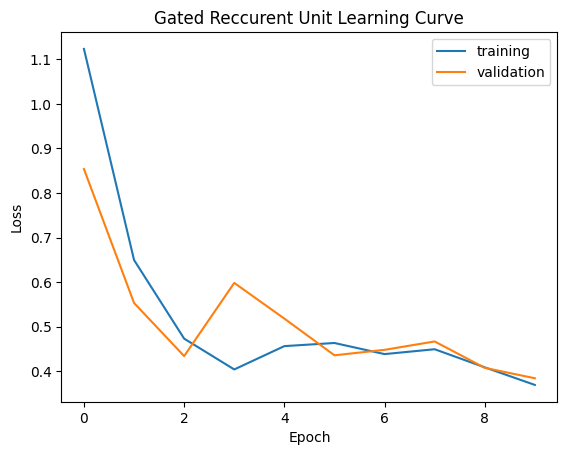

In [44]:
gru.plot_learning_curves()

In [45]:
gru_pred = gru.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


In [46]:
metrics = evaluate_performance(y_test, gru_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{gru.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Gated Reccurent Unit performance evaluation:

accuracy	0.8702777777777778.
precision	0.8733228474249511.
recall		0.8716358252770902.
f1-score	0.8716699518032752.


In [47]:
gru_report = classification_report(y_test, gru_pred, target_names=CLASS_NAMES)
print(gru_report)

              precision    recall  f1-score   support

         doc       0.97      0.99      0.98       287
         pdf       0.93      0.85      0.89       317
          ps       0.98      0.98      0.98       287
         xls       0.94      0.92      0.93       304
         ppt       0.86      0.87      0.86       307
         swf       0.72      0.77      0.75       307
         gif       0.90      0.78      0.83       308
         jpg       0.84      0.87      0.85       295
         png       0.79      0.84      0.81       311
        html       0.84      0.86      0.85       303
         txt       0.83      0.91      0.87       285
         xml       0.88      0.83      0.86       289

    accuracy                           0.87      3600
   macro avg       0.87      0.87      0.87      3600
weighted avg       0.87      0.87      0.87      3600



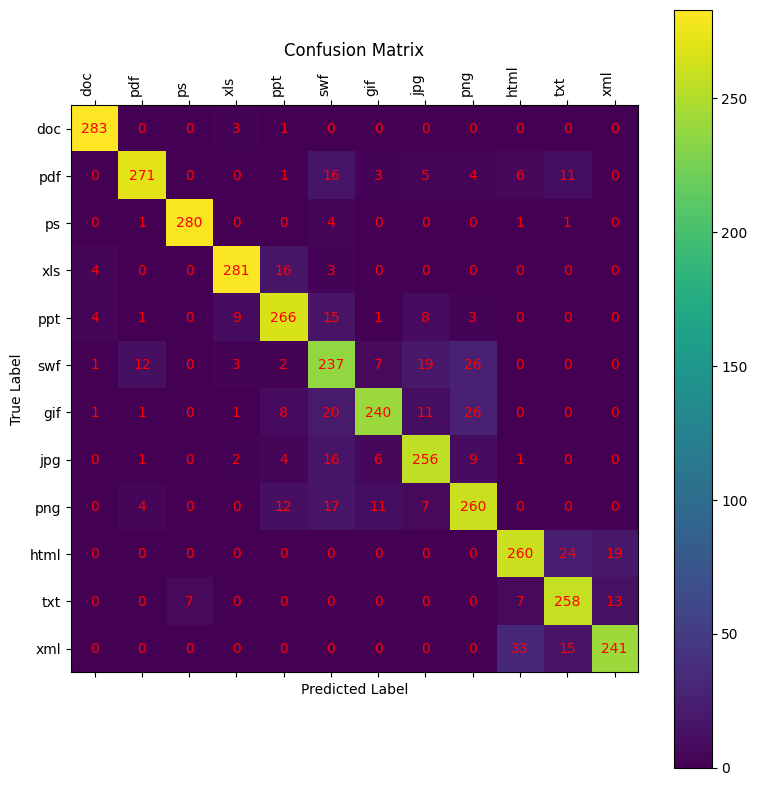

In [48]:
gru_cm = confusion_matrix(y_test, gru_pred)
plot_confusion_matrix(gru_cm, CLASS_NAMES)

### Long Short-Term Memory

In [49]:
lstm = Lstm(timesteps=256, features=1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 136)            │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,861 (155.71 KB)

 Trainable params: 39,861 (155.71 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 52s 93ms/step - accuracy: 0.5088 - loss: 1.4080 - val_accuracy: 0.6236 - val_loss: 0.9321
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.7116 - loss: 0.7813 - val_accuracy: 0.7883 - val_loss: 0.6259
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.7971 - loss: 0.5822 - val_accuracy: 0.8253 - val_loss: 0.5321
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.8351 - loss: 0.4926 - val_accuracy: 0.8428 - val_loss: 0.4688
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.8497 - loss: 0.4538 - val_accuracy: 0.8614 - val_loss: 0.4281
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.8682 - loss: 0.4191 - val_accuracy: 0.8694 - val_loss: 0.4010
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.8688 - loss: 0.3994 - val_accuracy: 0.8697 - val_loss: 0.3995
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.8753 - loss: 0.3793 - 

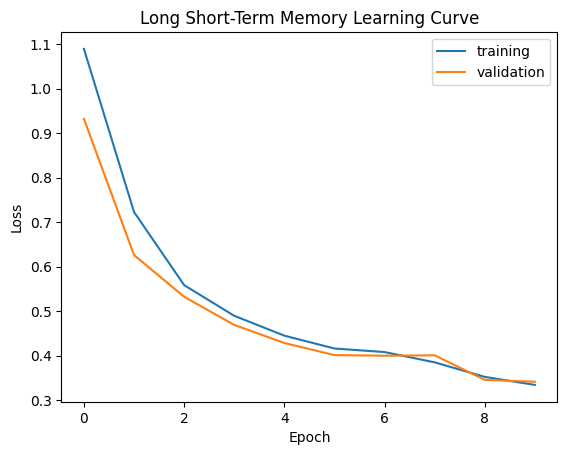

In [51]:
lstm.plot_learning_curves()

In [52]:
lstm_pred = lstm.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


In [53]:
metrics = evaluate_performance(y_test, lstm_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{lstm.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Long Short-Term Memory performance evaluation:

accuracy	0.8836111111111111.
precision	0.8882065481369453.
recall		0.8849370696917886.
f1-score	0.8847797186718659.


In [54]:
lstm_report = classification_report(y_test, lstm_pred, target_names=CLASS_NAMES)
print(lstm_report)

              precision    recall  f1-score   support

         doc       0.97      0.98      0.97       287
         pdf       0.96      0.87      0.91       317
          ps       0.99      0.94      0.96       287
         xls       0.99      0.96      0.98       304
         ppt       0.89      0.88      0.88       307
         swf       0.79      0.79      0.79       307
         gif       0.94      0.88      0.91       308
         jpg       0.75      0.94      0.84       295
         png       0.85      0.79      0.82       311
        html       0.88      0.79      0.83       303
         txt       0.85      0.91      0.88       285
         xml       0.81      0.90      0.85       289

    accuracy                           0.88      3600
   macro avg       0.89      0.88      0.88      3600
weighted avg       0.89      0.88      0.88      3600



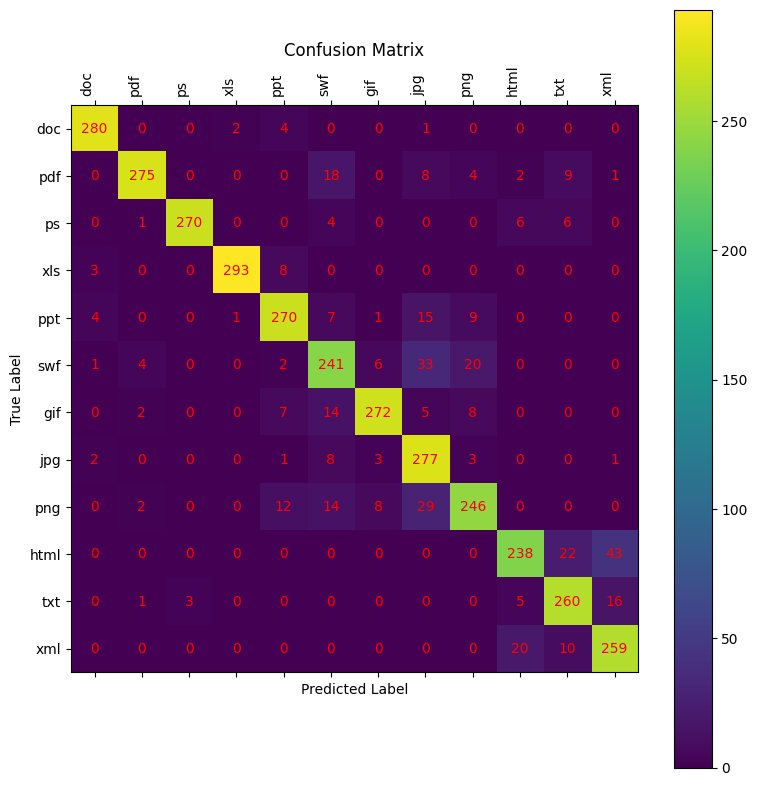

In [55]:
lstm_cm = confusion_matrix(y_test, lstm_pred)
plot_confusion_matrix(lstm_cm, CLASS_NAMES)